# Ames Housing
## Modeling
### Feature Selection

In [1]:
# Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn import metrics
from sklearn.feature_selection import RFE

In [2]:
pd.set_option('display.max_columns', 500) # This will allow me to view 500 rows in the notebook
pd.set_option('display.max_rows', 500) # This will allow me to view 500 rows in the notebook

In [3]:
df_train = pd.read_csv('./datasets/train_clean.csv') # This is what we'll need to work with!
df_test = pd.read_csv('./datasets/test_clean.csv') # We won't touch this until after we've created model

In [4]:
# Setting the index for our data frame according to one of the columns (Id)
df_train = df_train.set_index('Id')
df_test = df_test.set_index('Id')

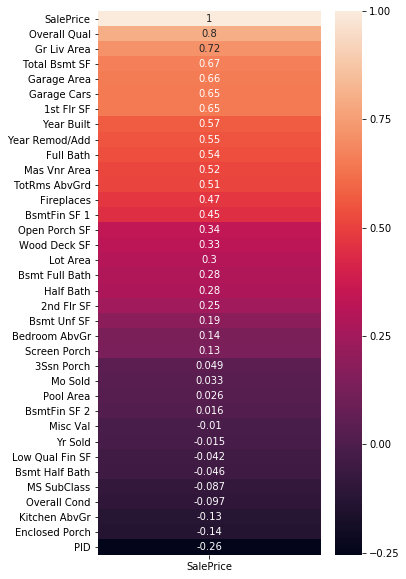

In [5]:
# Checking which variables are most correlated with sale price (from EDA)
plt.figure(figsize=(5,10))
sns.heatmap(df_train.corr()[['SalePrice']].sort_values(by='SalePrice',ascending=False), annot=True);

In [6]:
# Listing correlated features to use as candidate features in the model
corr_features = [
    'Lot Area', 
    'Overall Qual', 
    'Year Built', 
    'Year Remod/Add', 
    'Mas Vnr Area', 
    'Total Bsmt SF',
    'BsmtFin SF 1',
    'TotRms AbvGrd',
    '1st Flr SF', 
    'Gr Liv Area', 
    'Full Bath', 
    'Half Bath',
    'Fireplaces', 
    'Garage Area', 
    'Garage Cars',
    'Wood Deck SF', 
    'Open Porch SF', 
    'Enclosed Porch'
]

#### Dummy Variables

In [7]:
# Making a list of all the nominal data to dummy
nominal_data = [
    'MS SubClass', 
    'MS Zoning', 
    'Lot Shape', 
    'Land Contour', 
    'Utilities', 
    'Lot Config', 
    'Land Slope', 
    'Neighborhood', 
    'Condition 1', 
    'Condition 2', 
    'Bldg Type', 
    'House Style', 
    'Roof Style', 
    'Roof Matl', 
    'Exterior 1st', 
    'Exterior 2nd', 
    'Mas Vnr Type', 
    'Foundation', 
    'BsmtFin Type 1', 
    'BsmtFin Type 2', 
    'Heating', 
    'Central Air', 
    'Electrical', 
    'Functional', 
    'Garage Type', 
    'Garage Finish', 
    'Paved Drive', 
    'Sale Type'
]

In [8]:
# Making a list of the ordinal data to dummy. 
ordinal_data = [
    'Overall Cond',
    'Exter Qual',
    'Exter Cond',
    'Bsmt Qual',
    'Bsmt Cond',
    'Bsmt Exposure',
    'Heating QC',
    'Kitchen Qual',
    'Garage Qual',
    'Garage Cond'
]

In [9]:
# Creating dummy variables for our nominal data
for col in nominal_data:
    df_train = pd.get_dummies(df_train, columns=[col], drop_first=True)
    df_test = pd.get_dummies(df_test, columns=[col], drop_first=True)

In [10]:
# Creating dummy variables for our ordinal data
for col in ordinal_data:
    df_train = pd.get_dummies(df_train, columns=[col], drop_first=True)
    df_test = pd.get_dummies(df_test, columns=[col], drop_first=True)

One thing I would like to go back to and improve is turning ordinal data into numeric data and examining the relationship to sale price. This will likely give a more accurate model, as I am losing some information by one hot encoding these variables.

In [11]:
neighborhood_features = [col for col in df_test.columns if col[0] == 'N']

I suspect neighborhood will be able to explain a lot of the variance in sale price, so I created a list of each neighborhood to use as candidate features.

In [12]:
#df_train.corr()['SalePrice'] # Checking which dummy variables are correlated to sale price

I commented this line out because it was a very long list. I used this to pick out the most correlated dummy variables to use as candidate features.

In [13]:
# Creating a list of the most correlated dummy variables to use as candidate features
d_corr_features = [
    'MS SubClass_60',
    'Lot Shape_Reg',
    'House Style_2Story',
    'Roof Style_Hip',
    'Sale Type_New', 
    'Paved Drive_Y', 
    'Garage Finish_Unf', 
    'Garage Type_Detchd', 
    'Foundation_PConc', 
    'Foundation_Stone',
    'Mas Vnr Type_None',
    'Mas Vnr Type_Stone',
    'BsmtFin Type 1_GLQ',
    'Exterior 1st_VinylSd',
    'Central Air_Y',
    'Electrical_SBrkr',
    'MS Zoning_RM',
    'Land Contour_HLS',
    'Roof Style_Gable',
    'Exterior 1st_Wd Sdng',
    'Mas Vnr Type_BrkFace',
    'Garage Type_None',
    'Garage Type_BuiltIn'
]

In [14]:
# Creating a list of all the dummy columns for the ordinal data
ordinal_features_temp = list(df_train.columns[-47:])
# I have to remove some of the columns because they are not present in the test set
ordinal_features_remove = ['Bsmt Exposure_Missing', 'Heating QC_Po', 'Garage Qual_Fa', 'Bsmt Cond_Po', 'Bsmt Cond_Fa']
ordinal_features = [item for item in ordinal_features_temp if item not in ordinal_features_remove]

### Feature Engineering
I tried engineering these two features:
- after 2000: After 2000 is a binary feature that takes in 1 if the house was built after the year 2000 and 0 if built during or before the year 2000. The idea behind this came from the EDA. When plotting year built against sale price, I noticed a sharp increase in value for houses that were built after 2000. I leave this feature out though because it did not improve my model.
- year_2: Year-squared was an interaction term I tried because it seemed like year built had more of a quadratic relationship to sale price. I also leave this feature out of the model because it did not improve it.

In [25]:
df_train['after_2000'] = df_train['Year Built'].map(lambda x: 2 if x>=2000 else 0)
df_test['after_2000'] = df_test['Year Built'].map(lambda x: 2 if x>=2000 else 0)

In [26]:
df_train['year_2'] = df_train['Year Built']**2
df_test['year_2'] = df_test['Year Built']**2

In [27]:
# Combining all of the candidate features into one list
candidate_features = corr_features + neighborhood_features + d_corr_features + ordinal_features + ['after_2000', 'year_2']

### Test Model

In [28]:
# Defining our feature vector and training and test sets
features = candidate_features
X_train = df_train[features]
y_train = df_train['SalePrice']
X_test = df_test[features]

In [29]:
# Scaling our features
ss=StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [30]:
lr = LinearRegression() # Creating an instance of the model
cross_val_score(lr, X_train, y_train, cv=3) # Checking the cross value score to get an idea of the variance

array([-1.22771147e+20,  9.11552931e-01, -1.58760332e+22])

In [31]:
lr.fit(X_train, y_train) # Fitting the model
lr.score(X_train, y_train) # Checking the r^2 score

0.922149074244813

In [32]:
y_train_predictions = lr.predict(X_train)  # familiar data
np.sqrt(metrics.mean_squared_error(y_train, y_train_predictions)) # Checking the root mean squared error

22119.57064933859

### Pruning Features
I found this function at https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b.

In [33]:
len(candidate_features) # Checking the size of the features

110

In [34]:
#no of features
nof_list=np.arange(1,110)            
high_score=0
#Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):
    X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_train, y_train, random_state = 0)
    model = LinearRegression()
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train_1,y_train_1)
    X_test_rfe = rfe.transform(X_test_1)
    model.fit(X_train_rfe,y_train_1)
    score = model.score(X_test_rfe,y_test_1)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 65
Score with 65 features: 0.919065


In [35]:
cols = list(df_train[features])

rfe = RFE(lr, 65)             
#Transforming data using RFE
X_rfe = rfe.fit_transform(X_train,y_train)  
#Fitting the data to model
lr.fit(X_rfe,y_train)              
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

Index(['Lot Area', 'Overall Qual', 'Year Built', 'Year Remod/Add',
       'Mas Vnr Area', 'Total Bsmt SF', 'BsmtFin SF 1', 'TotRms AbvGrd',
       'Gr Liv Area', 'Half Bath', 'Fireplaces', 'Garage Area', 'Wood Deck SF',
       'Neighborhood_Crawfor', 'Neighborhood_Edwards', 'Neighborhood_Gilbert',
       'Neighborhood_Mitchel', 'Neighborhood_NAmes', 'Neighborhood_NWAmes',
       'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_OldTown',
       'Neighborhood_SawyerW', 'Neighborhood_Somerst', 'Neighborhood_StoneBr',
       'MS SubClass_60', 'House Style_2Story', 'Roof Style_Hip',
       'Sale Type_New', 'Paved Drive_Y', 'Foundation_PConc',
       'Mas Vnr Type_None', 'Mas Vnr Type_Stone', 'Electrical_SBrkr',
       'MS Zoning_RM', 'Land Contour_HLS', 'Mas Vnr Type_BrkFace',
       'Garage Type_None', 'Garage Type_BuiltIn', 'Overall Cond_2',
       'Overall Cond_3', 'Overall Cond_4', 'Overall Cond_5', 'Overall Cond_6',
       'Overall Cond_7', 'Overall Cond_8', 'Overall Cond_

In [36]:
selected_features_RFE = list(selected_features_rfe) #Saving the selected features to a list

### Linear Model

In [37]:
# Defining our feature vector and training and test sets
features = selected_features_RFE
X_train = df_train[features]
X_test = df_test[features]

In [38]:
# Scaling our features
ss=StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [39]:
lr_model = LinearRegression() # Creating an instance of the model
cross_val_score(lr_model, X_train, y_train, cv=3) # Checking the cross value score to get an idea of the variance

array([0.90575174, 0.9156474 , 0.90957443])

In [40]:
lr.fit(X_train, y_train) # Fitting the model
lr.score(X_train, y_train) # Checking the r^2 score

0.9214175763386165

In [41]:
y_train_predictions = lr.predict(X_train)  # familiar data
np.sqrt(metrics.mean_squared_error(y_train, y_train_predictions)) # Checking the root mean squared error

22223.24692952773

### Ridge Regularization

In [42]:
r_alphas = np.logspace(0,5,100)
ridge_model = RidgeCV(alphas=r_alphas, scoring='r2', cv=5)
ridge_model=ridge_model.fit(X_train, y_train)

In [43]:
r_predictions = ridge_model.predict(X_train)
np.sqrt(metrics.mean_squared_error(y_train, r_predictions))

22255.685405553435

### Lasso Regularization

In [44]:
l_alphas = np.logspace(-3, 0, 100)
lasso_model = LassoCV(alphas=l_alphas, cv=5)
lasso_model = lasso_model.fit(X_train, y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 261442199083.57324, tolerance: 1028595438.1318634
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 266205511147.50287, tolerance: 1028595438.1318634
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 270885617897.84344, tolerance: 1028595438.1318634
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You mi

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 378726325402.35455, tolerance: 1028595438.1318634
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 379470035093.601, tolerance: 1028595438.1318634
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 380171334391.7943, tolerance: 1028595438.1318634
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 390970368027.2378, tolerance: 1028595438.1318634
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 391021670590.3307, tolerance: 1028595438.1318634
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 391070058019.35974, tolerance: 1028595438.1318634
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You migh

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 371616030239.1575, tolerance: 1042003399.6978483
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 373750767989.53204, tolerance: 1042003399.6978483
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 375759981415.3341, tolerance: 1042003399.6978483
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You migh

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 406621031749.04944, tolerance: 1042003399.6978483
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 406762206555.5982, tolerance: 1042003399.6978483
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 406895613499.8693, tolerance: 1042003399.6978483
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You migh

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 362076296448.02484, tolerance: 1023889384.75354
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 364500366672.52966, tolerance: 1023889384.75354
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 366779514987.166, tolerance: 1023889384.75354
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 401382339126.4182, tolerance: 1023889384.75354
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 401537183241.26465, tolerance: 1023889384.75354
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 401683405505.59247, tolerance: 1023889384.75354
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might wan

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 355654922126.1195, tolerance: 1053741855.9903548
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 358470624974.43024, tolerance: 1053741855.9903548
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 361118496276.6936, tolerance: 1053741855.9903548
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You migh

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 401806550704.5431, tolerance: 1053741855.9903548
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 401982355102.45435, tolerance: 1053741855.9903548
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 402148534991.90344, tolerance: 1053741855.9903548
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You mig

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 196400900286.83698, tolerance: 1002352722.0397116
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 208609956194.74207, tolerance: 1002352722.0397116
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 219978650198.5108, tolerance: 1002352722.0397116
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You mig

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 375127068683.80884, tolerance: 1002352722.0397116
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 375791385577.0338, tolerance: 1002352722.0397116
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 376418354114.0797, tolerance: 1002352722.0397116
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You migh

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 506586089462.9325, tolerance: 1287750012.7032332
  positive)


In [45]:
l_predictions = lasso_model.predict(X_train)
np.sqrt(metrics.mean_squared_error(y_train, l_predictions))

22243.080005019645

### Kaggle Submission

In [46]:
X_kaggle = df_test[features]

In [50]:
X_kaggle['SalePrice'] = ridge_model.predict(X_test)
X_kaggle.head()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Lot Area,Overall Qual,Year Built,Year Remod/Add,Mas Vnr Area,Total Bsmt SF,BsmtFin SF 1,TotRms AbvGrd,Gr Liv Area,Half Bath,Fireplaces,Garage Area,Wood Deck SF,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,MS SubClass_60,House Style_2Story,Roof Style_Hip,Sale Type_New,Paved Drive_Y,Foundation_PConc,Mas Vnr Type_None,Mas Vnr Type_Stone,Electrical_SBrkr,MS Zoning_RM,Land Contour_HLS,Mas Vnr Type_BrkFace,Garage Type_None,Garage Type_BuiltIn,Overall Cond_2,Overall Cond_3,Overall Cond_4,Overall Cond_5,Overall Cond_6,Overall Cond_7,Overall Cond_8,Overall Cond_9,Exter Qual_Fa,Exter Qual_Gd,Exter Qual_TA,Bsmt Qual_Fa,Bsmt Qual_Gd,Bsmt Qual_TA,Bsmt Exposure_Gd,Bsmt Exposure_Mn,Bsmt Exposure_No,Heating QC_TA,Kitchen Qual_Fa,Kitchen Qual_Gd,Kitchen Qual_TA,Garage Qual_Gd,Garage Qual_TA,Garage Cond_None,after_2000,year_2,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2658,9142,6,1910,1950,0.0,1020,0,9,1928,0,0,440.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,3648100,156090.318783
2718,9662,5,1977,1977,0.0,1967,0,10,1967,0,0,580.0,170,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,1,0,0,1,0,1,0,0,3908529,176969.234309
2414,17104,7,2006,2006,0.0,654,554,7,1496,1,1,426.0,100,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,1,1,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,2,4024036,215752.912246
1989,8520,5,1923,2006,0.0,968,0,5,968,0,0,480.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,3697929,101088.183116
625,9500,6,1963,1963,247.0,1394,609,6,1394,1,2,514.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,1,0,0,3853369,168278.790993


In [51]:
output = X_kaggle[['SalePrice']]
output.head()

,SalePrice
Id,
2658,156090.318783
2718,176969.234309
2414,215752.912246
1989,101088.183116
625,168278.790993


In [52]:
#output.to_csv("./datasets/submission_final_ridge.csv")